# Predicción del precio de una casa

<p>En esta sección se trabajará con el dataset <i>Boston Housing</i>, el objetivo de este dataset es predecir el valor de una casa en una determinada zona residencial a partir de un conjunto de valores relacionados a la casa, como por ejemplo, la tasa de criminalidad, contaminación atmosférica, entre otros.  </p>

In [77]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras.regularizers import l1, l2

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

## Importacion de los datos
<p>A continuación, se importa el dataset a utilizar, cabe señalar que, al momento de realizar la importación de los datos, la fuente indicada en el enunciado no se encontraba disponible, por lo que se utilizó una fuente “equivalente” para obtener los datos. Además se crean los conjuntos de datos para el entrenamiento y las pruebas.</p>

In [136]:
#url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
#df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX','RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
#df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)
#df.shape
#df.info()
#df.describe()
from sklearn.datasets import load_boston
boston = load_boston()
colums_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX','RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df = np.concatenate((boston['data'], boston['target'].reshape((506,1))), axis=1)
df_train, df_test = train_test_split(df,test_size=0.25, random_state=0)

<p>El dataset importado cuenta con 506 registros, los cuales están compuestos por 13 atributos numéricos/categóricos, los cuales  son utilizados para predecir el precio de las casas, la información del precio de cada casa se incluye como un parámetro extra y formando un total de 14 datos por registro.</p>
<p>A continuación, se muestra la información del dataset entregada por la fuente utilizada.</p>

In [134]:
print boston.DESCR[:-1072]

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

## Normalización de los datos
<p>En esta sección se normalizarán los datos del dataset, es decir se busca que los datos se comporten como una distribución normal, con una media igual a 0 y una variancia igual a 1, lo anterior con el objetivo de poder utilizar correctamente algunos algoritmos de aprendizaje, por ejemplo, los regularizadores l1 y l2, ya que estos asumen que los atributos predictivos están centrados en 0 y que los órdenes de magnitud de las variancias son similares, ya que si un predictor pose una variancia de mayor magnitud, en comparación a los otros predictores,  este tendera a dominar por sobre los otros, provocando que la maquina no aprenda correctamente como se esperaría.</p>

In [4]:
scaler = StandardScaler().fit(df_train)

X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=colums_names)
y_train_scaled = X_train_scaled.pop('MEDV')
Xm_train = X_train_scaled.as_matrix()
ym_train = y_train_scaled.as_matrix()

X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=colums_names)
y_test_scaled = X_test_scaled.pop('MEDV')
Xm_test = X_test_scaled.as_matrix()
ym_test = y_test_scaled.as_matrix()

## MSE vs <i>epochs</i> para la función sigmoidal
<p>Se busca estudiar el comportamiento del error cuadrático (MSE) en función del número de epochs de entrenamiento, para facilitar el estudio de esta relación y de futuros análisis, se define la función <i>do_model</i> la cual construye una red feedforward de 3 capas, donde la capa oculta está formada por 200 neuronas, con la cualidad de que tanto la función de activación y el optimizador, se pueden configurar.</p>

In [5]:
def do_model(m_input, m_activation, m_sgd):
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=m_input, kernel_initializer='uniform'))
    model.add(Activation(m_activation))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear'))
    
    # compile model
    model.compile(optimizer = m_sgd, loss='mean_squared_error')
    
    return model

<p>Se procede a construir y entrenar una red neuronal donde la función de activación de las neuronas en la capa oculta corresponde a una sigmoidal, y usando como optimizador un gradiente descendente estocástico con tasa de aprendizaje 0.01. Con los datos obtenidos del entrenamiento es posible graficar el error cuadrático en función de la cantidad de epochs, resultando en el gráfico presentado a continuación</p>

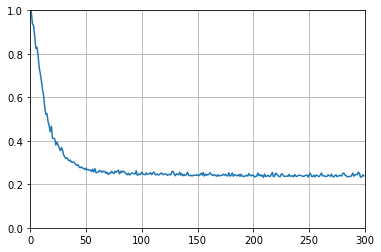

In [6]:
sgd = SGD(lr=0.01)
model = do_model(Xm_train.shape[1], 'sigmoid', sgd)

# fit the model
hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))

plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 1])
plt.grid(True)
plt.show()

<p>Del grafico anterior, es posible apreciar que la red neuronal converge pasada la iteración 50, además el valor de MSE converge a un valor cercano a 0.25, de igual manera se puede apreciar un leve nivel de divergencia, ya que se forma una curva con asperezas, pero la divergencia apreciada no es lo suficientemente grande como para provocar una incapacidad de la red al clasificar los datos. </p>

## MSE vs <i>epochs</i> para la función relu
<p>En este punto se crea una red de neuronas artificiales con la misma configuración usada en el punto anterior, excepto que en este caso la función de activación de las neuronas ocultas será una relu. Al entrenar la neurona, y obtener los valores perdida es posible realizar el grafico de la perdida en función a los epochs, el cual se muestra a continuación</p>

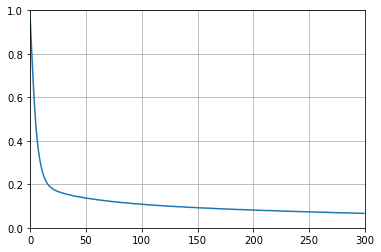

In [7]:
sgd = SGD(lr=0.01)
model = do_model(Xm_train.shape[1], 'relu', sgd)

# fit the model
hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))

plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 1])
plt.grid(True)
plt.show()

<p>En el gráfico anterior se puede apreciar que el mayor cambio de magnitud ocurre en el intervalo [0-50], pero a diferencia del gráfico obtenido para la función sigmoid, este no se estanca inmediatamente, lo que permite obtener un menor valor de MSE, lo cual implica que el modelo usando una función relu pose mejor clasificación que el modelo donde se utiliza la función sigmod.</p>

## Análisis de la tasa de aprendizaje 
<p>Para analizar la influencia de la tasa de aprendizaje en el comportamiento de las redes neuronales se utilizarán los 2 modelos creados con anterioridad, la red con la función sigmoid y la red con la función relu. Primero se estudiará el comportamiento de la función sigmoid, para esto se crearán y evaluarán redes neuronales donde el factor de aprendizaje varíe entre 0 y 0.03, los resultados se muestran a continuación</p>

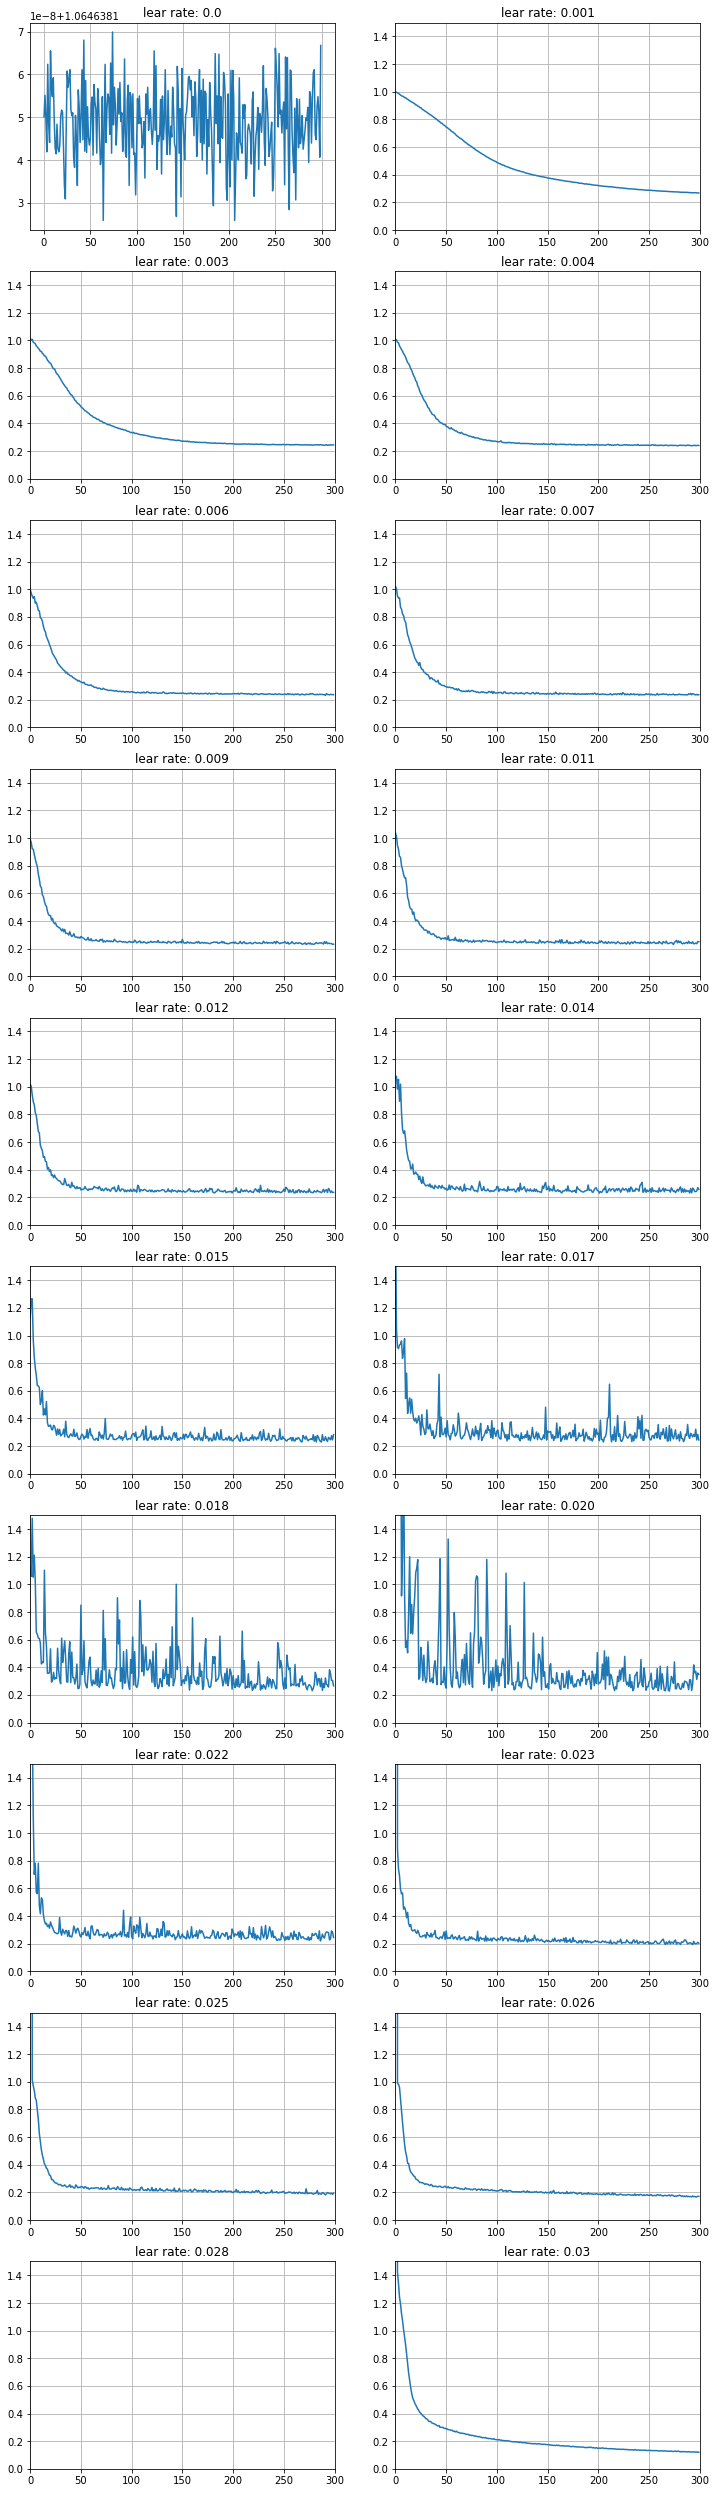

In [8]:
n_lr = 20
lear_rate = np.linspace(0,.03,n_lr)

x_cord=[i%2 for i in xrange(20)]
y_cord=[i/2 for i in xrange(20)]


f, axarr = plt.subplots(10, 2,figsize=(12,45))
for rate,x,y in zip(lear_rate,x_cord,y_cord):
    sgd = SGD(lr=rate)
    model = do_model(Xm_train.shape[1], 'sigmoid', sgd)

    # fit the model
    hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))
    
    axarr[y, x].plot(hist.history['loss'])
    axarr[y, x].set_title('lear rate: '+(str(rate)[:5]))
    axarr[y, x].grid(True)
    if (rate != 0): axarr[y, x].axis([0, 300, 0, 1.5])
    
plt.show()

<p>Del conjunto de gráficos anterior, como era de esperar cuando la tasa de aprendizaje es igual a 0 la red no es capaz de converger, para las redes con tasa de aprendizaje mayores a cero y menores a 0.012, se puede apreciar una clara convergencia y que la convergencia se alcanza con gran rapidez, además es posible apreciar que los valores de 0.007 y 0.009 minimizan la perdida generada. Para los valores de la tasa de aprendizaje mayores a 0.015 es posible apreciar que la red empezar a divergir a medida que aumenta el valor de la tasa de aprendizaje, lo cual se aprecia claridad en 0.02, por último, a de señalarse que para valores de tasa de aprendizaje mayores a 0.025 las redes no siempre eran capases de converger.</p>
<p>Para estudiar el comportamiento de la función relu al cambiar la tasa de aprendizaje, se realizó el mismo procedimiento seguido en la función sigmoid, solo que en este caso se probaron valores entre 0 y 0.47 para la tasa de aprendizaje, los resultados se muestran a continuación</p>

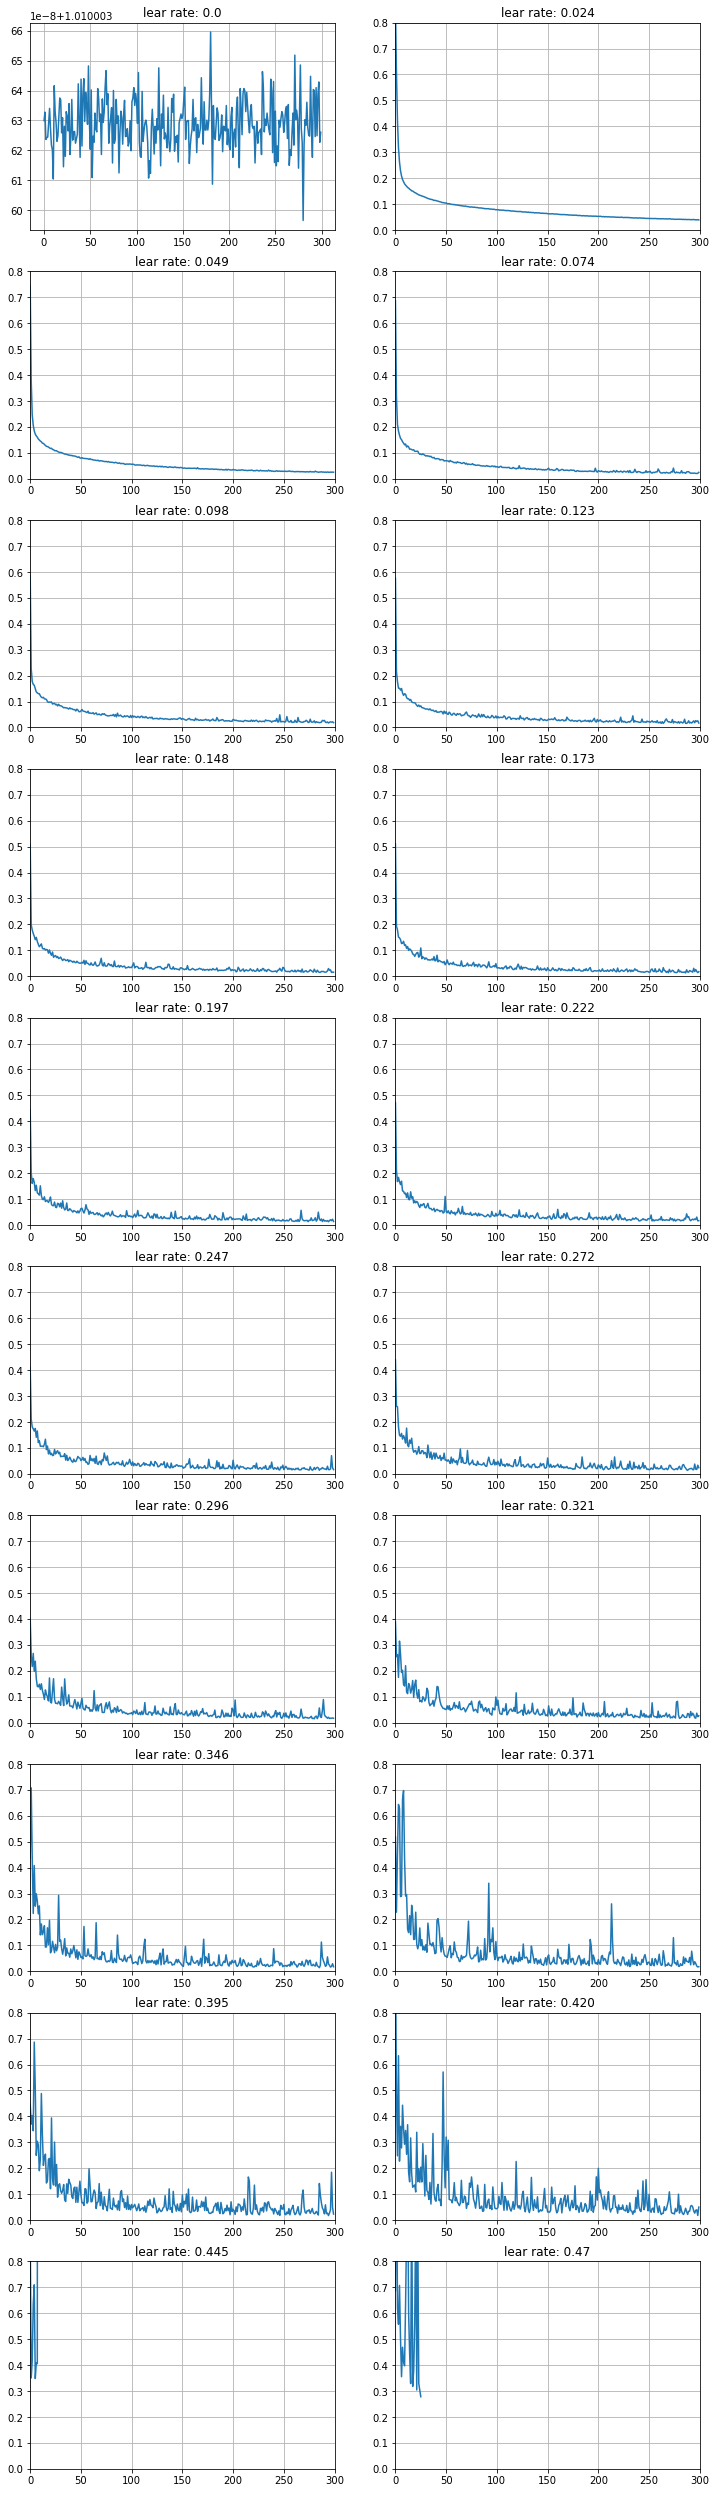

In [148]:
n_lr = 20
lear_rate = np.linspace(0,.47,n_lr)

x_cord=[i%2 for i in xrange(20)]
y_cord=[i/2 for i in xrange(20)]

f, axarr = plt.subplots(10, 2,figsize=(12,45))
for rate,x,y in zip(lear_rate,x_cord,y_cord):
    sgd = SGD(lr=rate)
    model = do_model(Xm_train.shape[1], 'relu', sgd)

    # fit the model
    hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))
    
    axarr[y, x].plot(hist.history['loss'])
    axarr[y, x].set_title('lear rate: '+(str(rate)[:5]))
    axarr[y, x].grid(True)
    if (rate != 0): axarr[y, x].axis([0, 300, 0, 0.8])
    
plt.show()

<p>De los resultados anteriores, era esperable que con una tasa de aprendizaje igual a 0 la red divergiera, con tasas de aprendizaje entre 0 y 0.19 la red converge sin problemas, y el mínimo valor de perdida debería estar entre 0.123 y 0.1733, es posible apreciar que la red empieza a presentar divergencias con tasas de aprendizaje mayores a 0.3, y para tasas mayores a 0.44 no fue posible construir una red neuronal.</p>

## Errror de prediccion con validación cruzada
<p></p>

In [159]:
# k = 10
kfold = cross_validation.KFold(len(Xm_train), 10)

cvscores = []
for i, (train, val) in enumerate(kfold):
    sgd = SGD(lr=0.01)
    model = do_model(Xm_train.shape[1], 'sigmoid', sgd)
    
    model.fit(Xm_train[train], ym_train[train], epochs=300, verbose=0)
    
    scores = model.evaluate( Xm_train[val], ym_train[val] )
    cvscores.append(scores)
    
mse_cv = np.mean(cvscores)
mse_cv

32/37 [========================>.....] - ETA: 0s

0.27949602680802765

In [158]:
# k = 5
kfold = cross_validation.KFold(len(Xm_train), 5)

cvscores = []
for i, (train, val) in enumerate(kfold):
    sgd = SGD(lr=0.01)
    model = do_model(Xm_train.shape[1], 'sigmoid', sgd)
    
    model.fit(Xm_train[train], ym_train[train], epochs=300, verbose=0)
    
    scores = model.evaluate( Xm_train[val], ym_train[val] )
    cvscores.append(scores)
    
mse_cv = np.mean(cvscores)
mse_cv

32/75 [===========>..................] - ETA: 0s

0.28115127785896005

In [144]:
# k = 10
kfold = cross_validation.KFold(len(Xm_train), 10)

cvscores = []
for i, (train, val) in enumerate(kfold):
    sgd = SGD(lr=0.01)
    model = do_model(Xm_train.shape[1], 'relu', sgd)
    
    model.fit(Xm_train[train], ym_train[train], epochs=300, verbose=0)
    
    scores = model.evaluate( Xm_train[val], ym_train[val] )
    cvscores.append(scores)
    
mse_cv = np.mean(cvscores)
mse_cv

32/37 [========================>.....] - ETA: 0s

0.14674294770484625

In [150]:
# k = 5
kfold = cross_validation.KFold(len(Xm_train), 5)

cvscores = []
for i, (train, val) in enumerate(kfold):
    sgd = SGD(lr=0.01)
    model = do_model(Xm_train.shape[1], 'relu', sgd)
    
    model.fit(Xm_train[train], ym_train[train], epochs=300, verbose=0)
    
    scores = model.evaluate( Xm_train[val], ym_train[val] )
    cvscores.append(scores)
    
mse_cv = np.mean(cvscores)
mse_cv

32/75 [===========>..................] - ETA: 0s

0.15251699189972459

## n decay

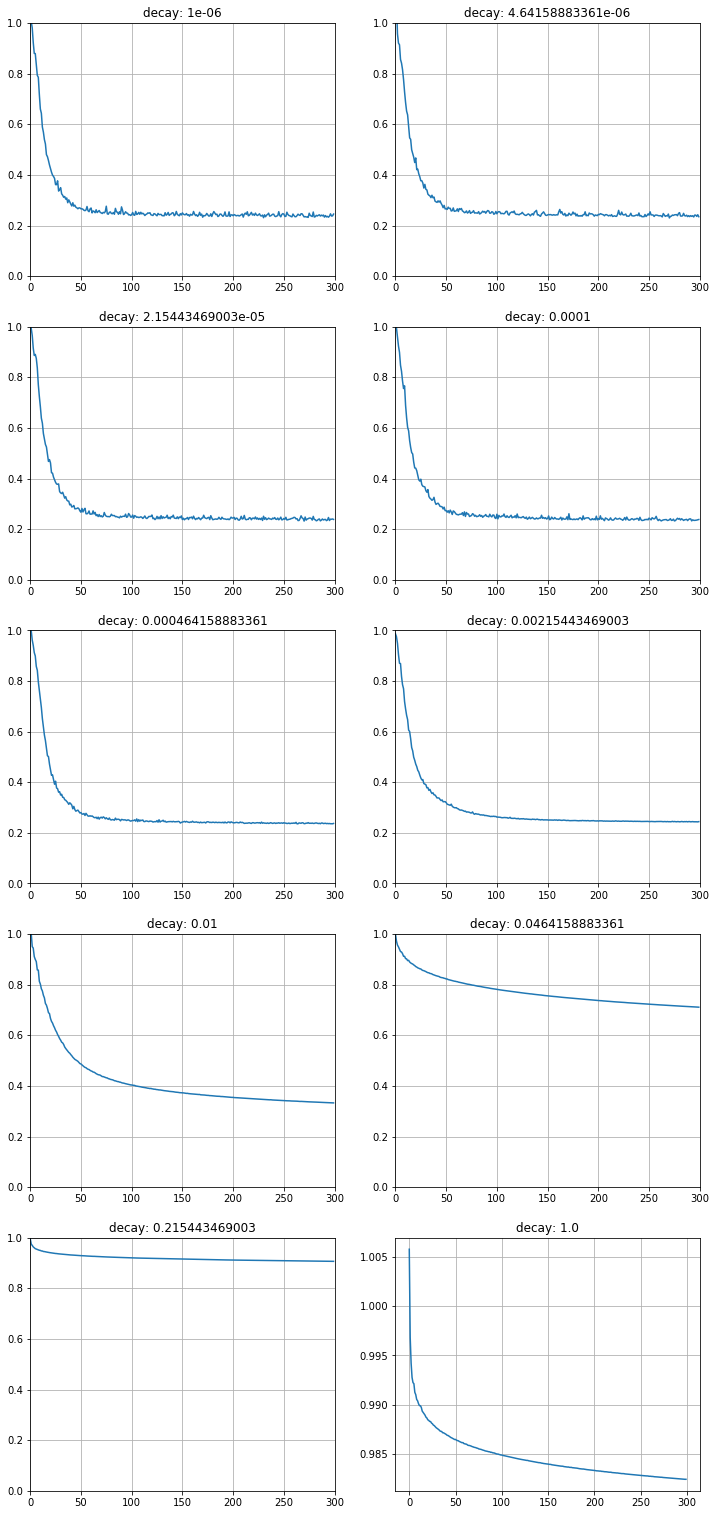

In [152]:
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)

x_cord=[i%2 for i in xrange(20)]
y_cord=[i/2 for i in xrange(20)]

f, axarr = plt.subplots(5, 2,figsize=(12,27))
for dec,x,y in zip(lear_decay,x_cord,y_cord):
    sgd = SGD(lr=0.01, decay=dec)
    model = do_model(Xm_train.shape[1], 'sigmoid', sgd)

    # fit the model
    hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))
    
    axarr[y, x].plot(hist.history['loss'])
    axarr[y, x].set_title('decay: '+(str(dec)))
    if (dec!=1): axarr[y, x].axis([0, 300, 0, 1])
    axarr[y, x].grid(True)
    
plt.show()

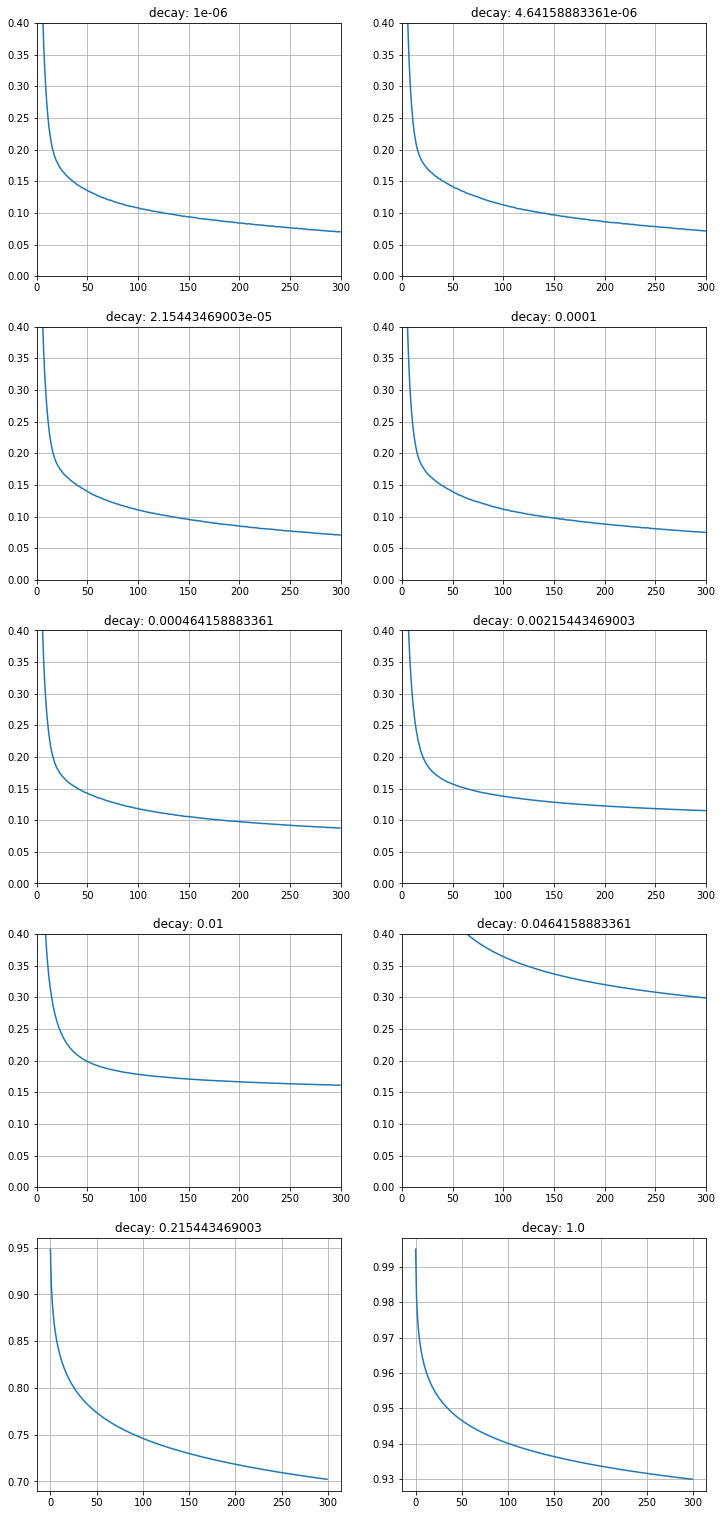

In [155]:
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)

x_cord=[i%2 for i in xrange(20)]
y_cord=[i/2 for i in xrange(20)]

f, axarr = plt.subplots(5, 2,figsize=(12,27))
for dec,x,y in zip(lear_decay,x_cord,y_cord):
    sgd = SGD(lr=0.01, decay=dec)
    model = do_model(Xm_train.shape[1], 'relu', sgd)

    # fit the model
    hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))
    
    axarr[y, x].plot(hist.history['loss'])
    axarr[y, x].set_title('decay: '+(str(dec)))
    if (y!=4): axarr[y, x].axis([0, 300, 0, .4])
    axarr[y, x].grid(True)
    
plt.show()

## momentum

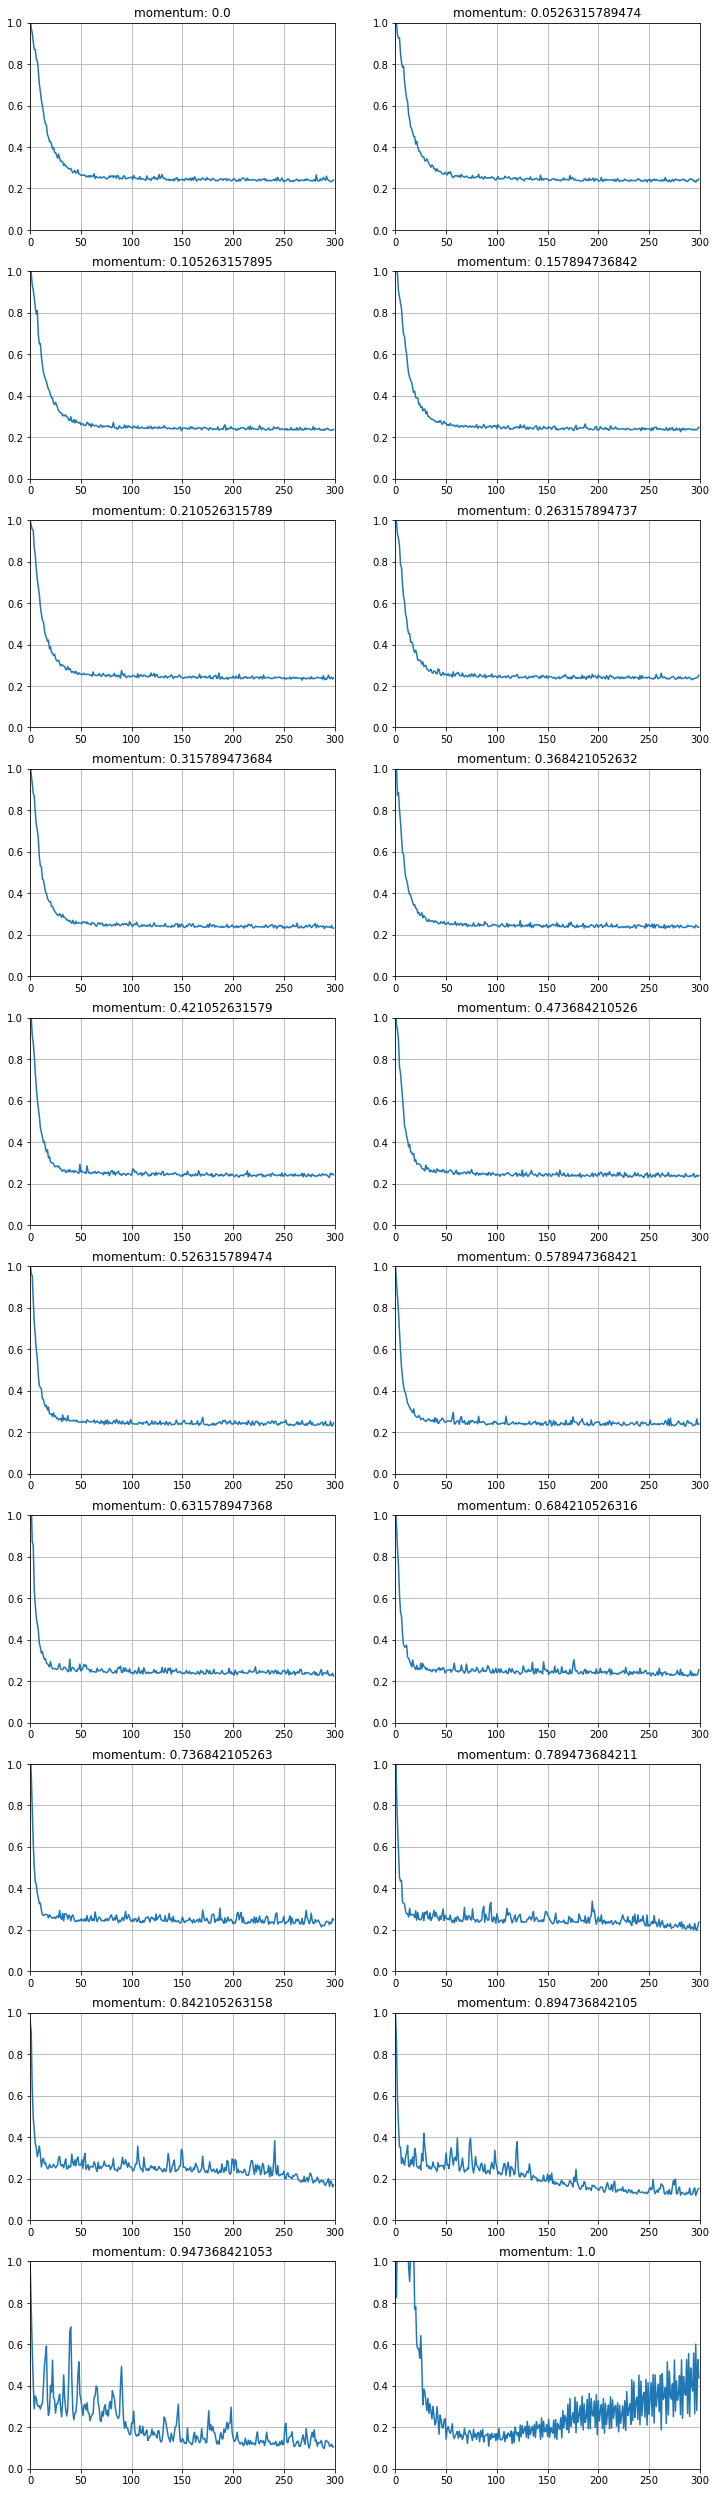

In [19]:
n_decay = 20
momentum = np.linspace(0,1,n_decay)

x_cord=[i%2 for i in xrange(20)]
y_cord=[i/2 for i in xrange(20)]

f, axarr = plt.subplots(10, 2,figsize=(12,45))
for mom,x,y in zip(momentum,x_cord,y_cord):
    sgd = SGD(lr=0.01,momentum=mom)
    model = do_model(Xm_train.shape[1], 'sigmoid', sgd)

    # fit the model
    hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))
    
    axarr[y, x].plot(hist.history['loss'])
    axarr[y, x].set_title('momentum: '+(str(mom)))
    axarr[y, x].axis([0, 300, 0, 1])
    axarr[y, x].grid(True)
    
plt.show()

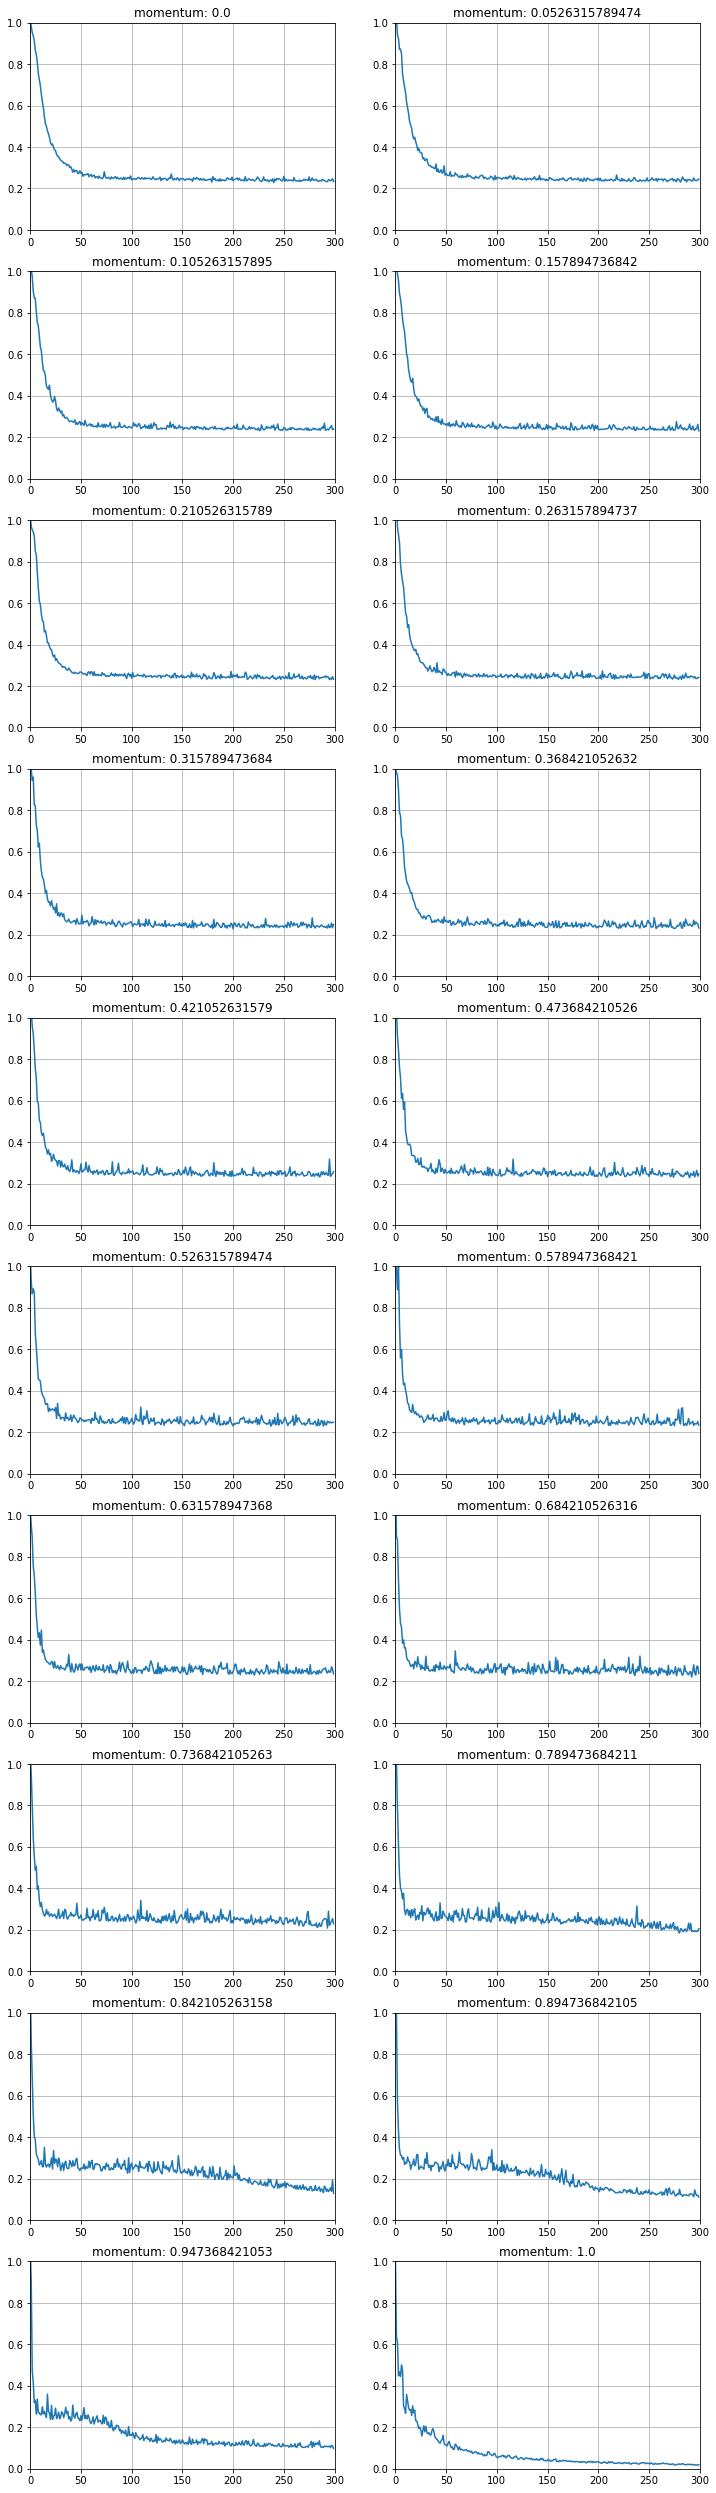

In [21]:
n_decay = 20
momentum = np.linspace(0,1,n_decay)

x_cord=[i%2 for i in xrange(20)]
y_cord=[i/2 for i in xrange(20)]

f, axarr = plt.subplots(10, 2,figsize=(12,45))
for mom,x,y in zip(momentum,x_cord,y_cord):
    sgd = SGD(lr=0.01,momentum=mom, nesterov=True)
    model = do_model(Xm_train.shape[1], 'sigmoid', sgd)

    # fit the model
    hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))
    
    axarr[y, x].plot(hist.history['loss'])
    axarr[y, x].set_title('momentum: '+(str(mom)))
    axarr[y, x].axis([0, 300, 0, 1])
    axarr[y, x].grid(True)
    
plt.show()

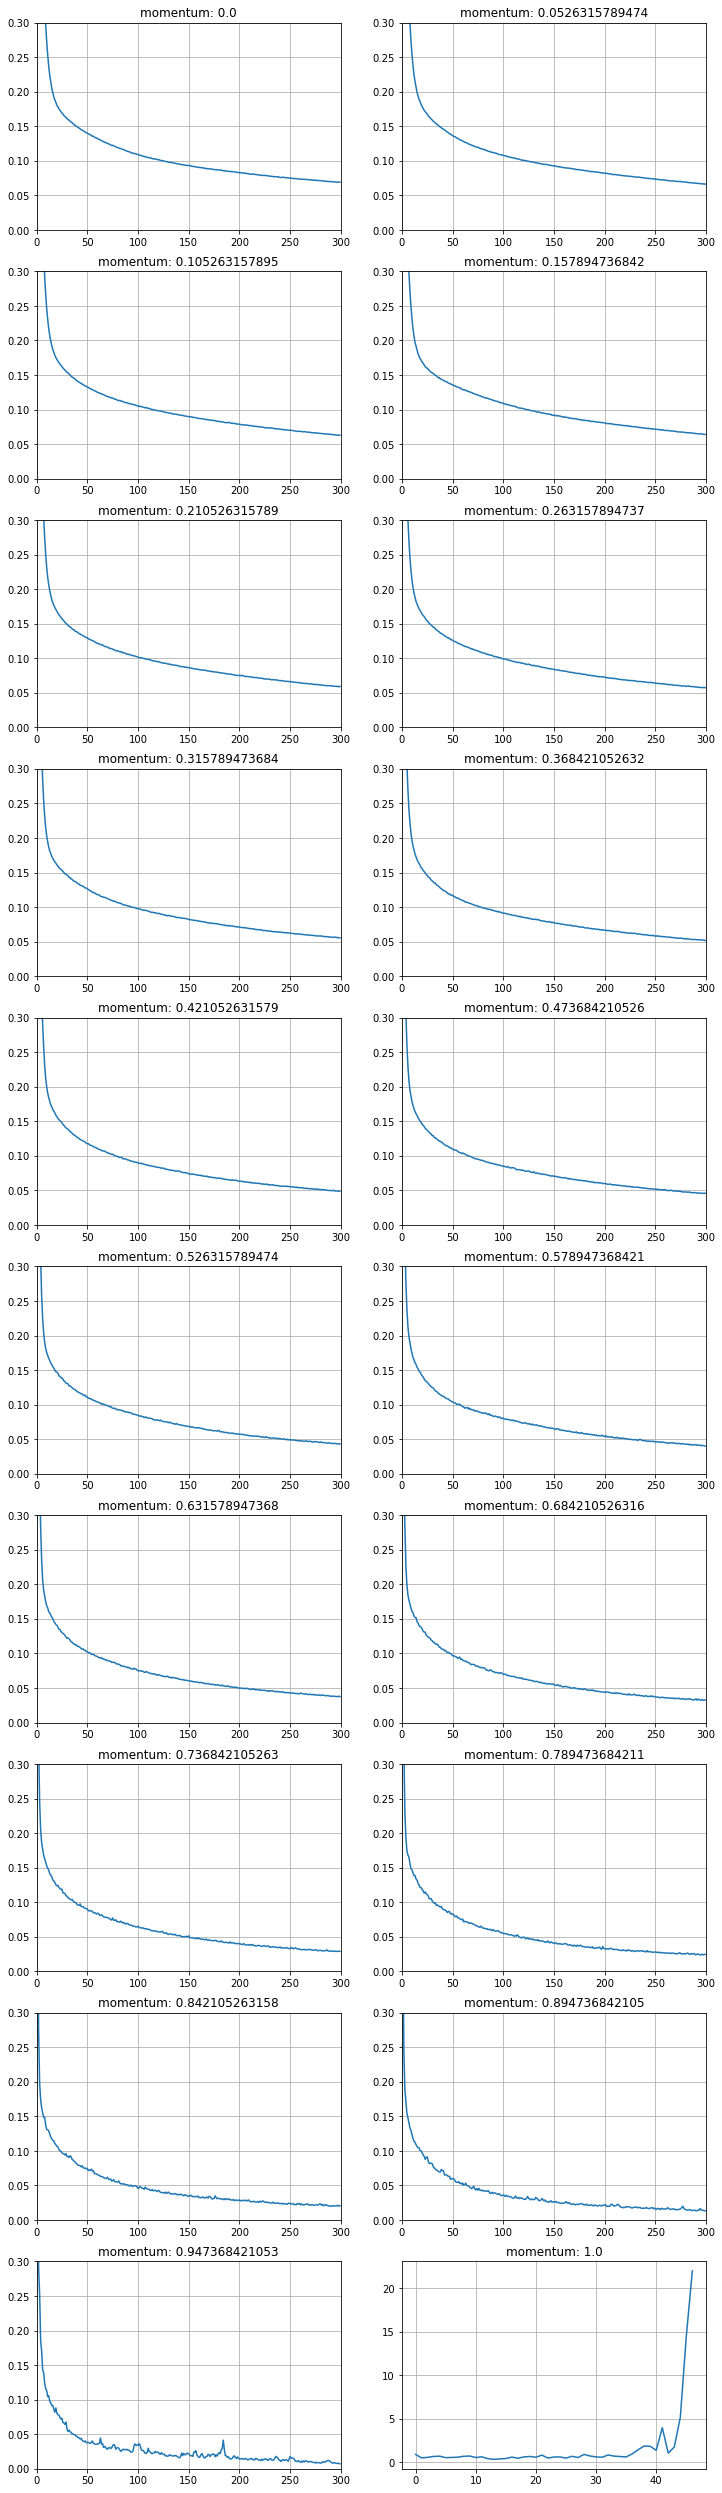

In [23]:
n_decay = 20
momentum = np.linspace(0,1,n_decay)

x_cord=[i%2 for i in xrange(20)]
y_cord=[i/2 for i in xrange(20)]

f, axarr = plt.subplots(10, 2,figsize=(12,45))
for mom,x,y in zip(momentum,x_cord,y_cord):
    sgd = SGD(lr=0.01,momentum=mom)
    model = do_model(Xm_train.shape[1], 'relu', sgd)

    # fit the model
    hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))
    
    axarr[y, x].plot(hist.history['loss'])
    axarr[y, x].set_title('momentum: '+(str(mom)))
    axarr[y, x].grid(True)
    if (mom != 1): axarr[y, x].axis([0, 300, 0, .3])
    
plt.show()

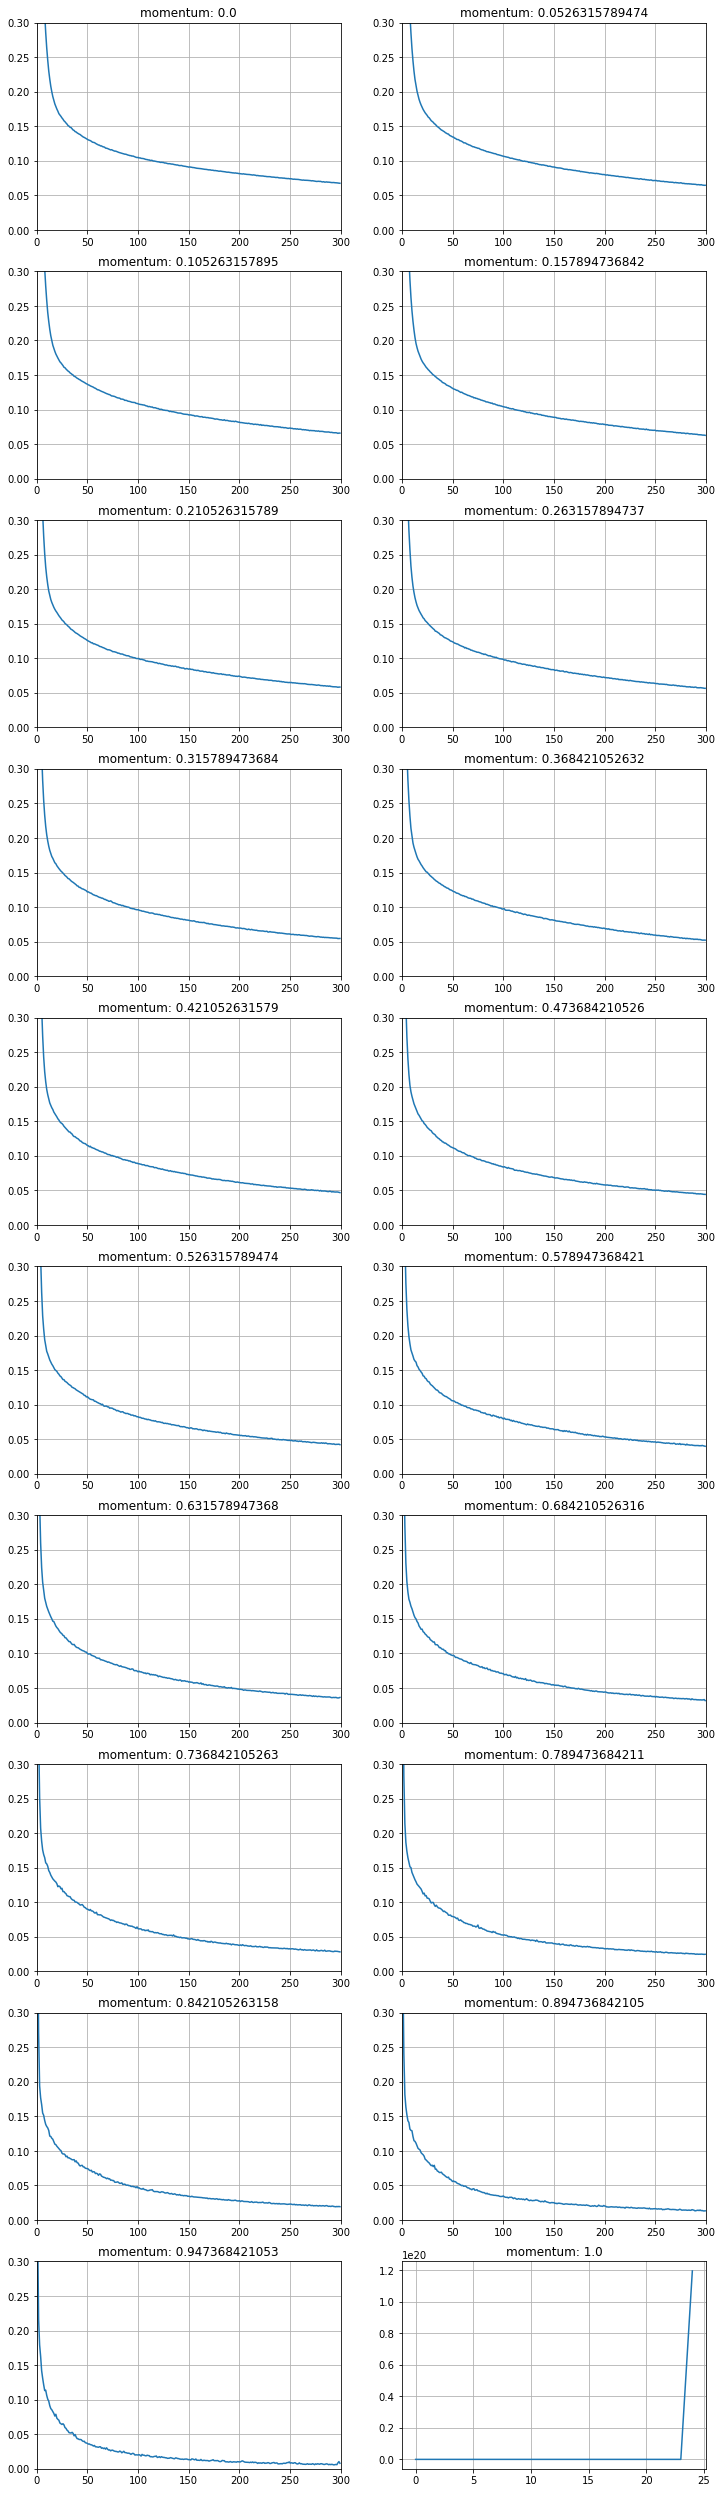

In [30]:
n_decay = 20
momentum = np.linspace(0,1,n_decay)

x_cord=[i%2 for i in xrange(20)]
y_cord=[i/2 for i in xrange(20)]

f, axarr = plt.subplots(10, 2,figsize=(12,45))
for mom,x,y in zip(momentum,x_cord,y_cord):
    sgd = SGD(lr=0.01, momentum=mom, nesterov=True)
    model = do_model(Xm_train.shape[1], 'relu', sgd)

    # fit the model
    hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))
    
    axarr[y, x].plot(hist.history['loss'])
    axarr[y, x].set_title('momentum: '+(str(mom)))
    axarr[y, x].grid(True)
    if (mom != 1): axarr[y, x].axis([0, 300, 0, .3])
    
plt.show()

## SGD en mini-batches

C:\Users\tres1\Anaconda2\lib\site-packages\keras\engine\training.py:1125: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  batch_ids = index_array[batch_start:batch_end]
C:\Users\tres1\Anaconda2\lib\site-packages\keras\engine\training.py:1249: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  batch_ids = index_array[batch_start:batch_end]


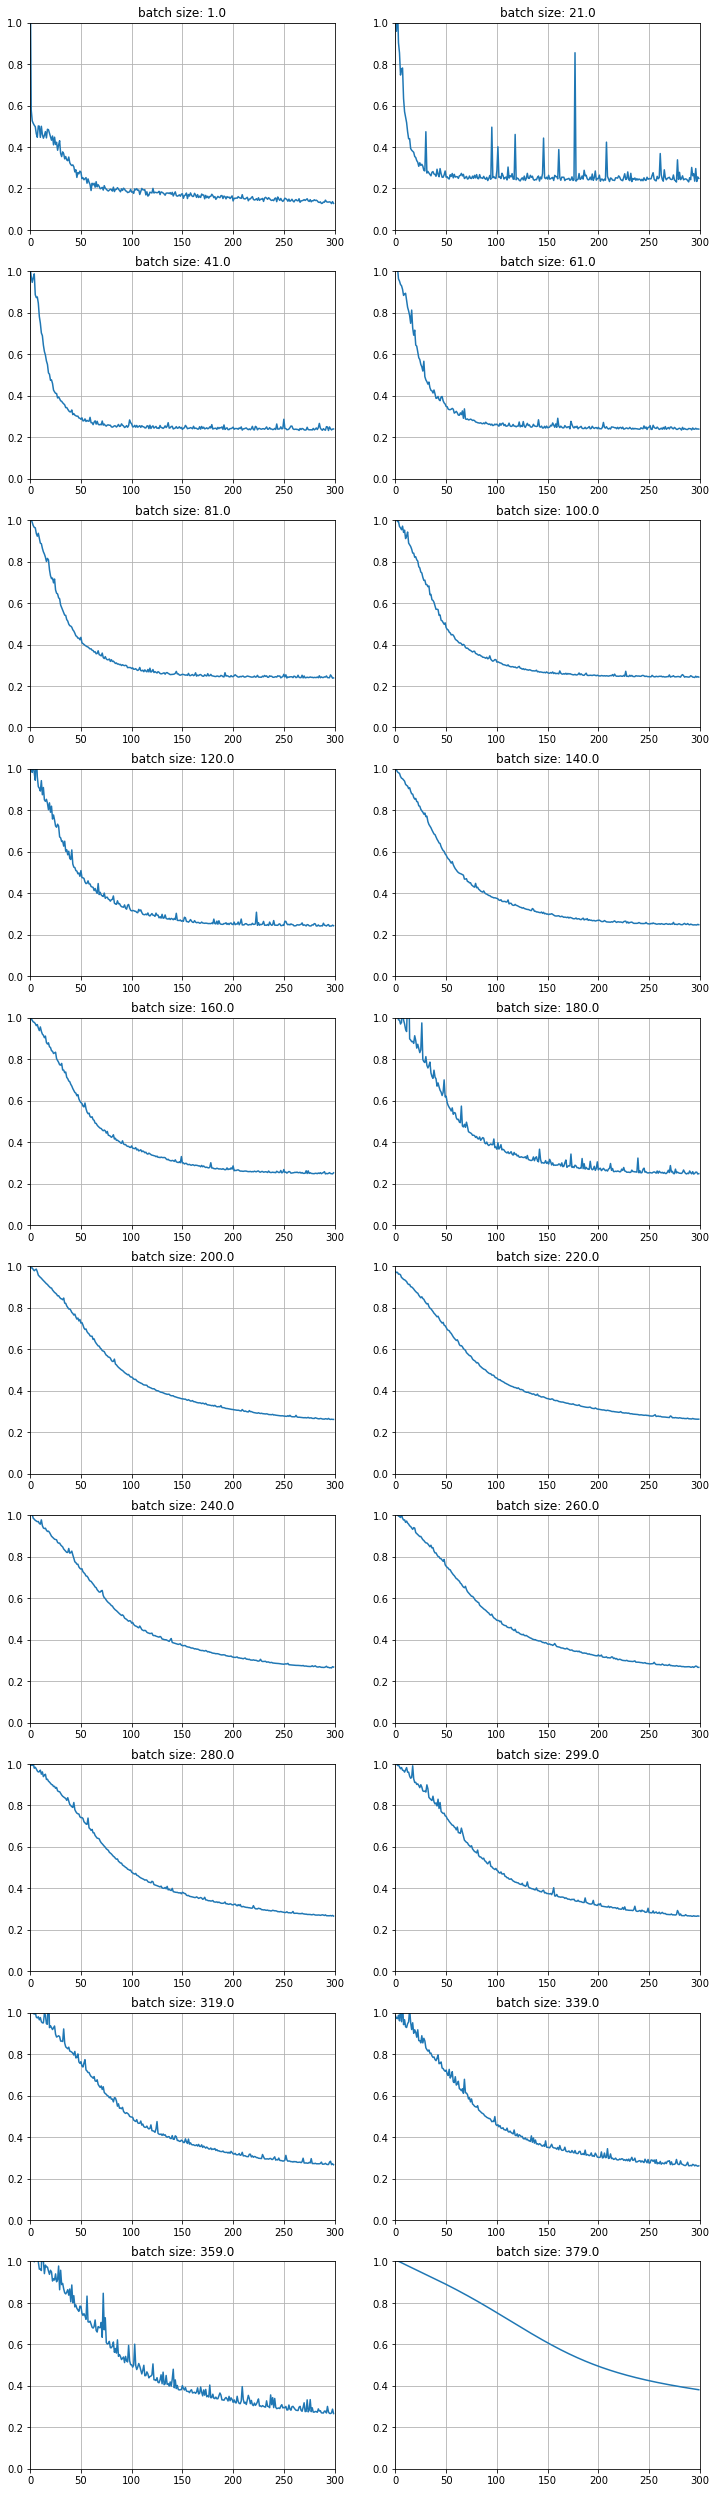

In [31]:
n_batches = 20
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))

x_cord=[i%2 for i in xrange(20)]
y_cord=[i/2 for i in xrange(20)]

f, axarr = plt.subplots(10, 2,figsize=(12,45))
for batch,x,y in zip(batch_sizes,x_cord,y_cord):
    sgd = SGD(lr=0.01)
    model = do_model(Xm_train.shape[1], 'sigmoid', sgd)
    
    # fit the model
    hist = model.fit(Xm_train, ym_train, batch_size=batch, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))
    
    axarr[y, x].plot(hist.history['loss'])
    axarr[y, x].set_title('batch size: '+(str(batch)))
    axarr[y, x].axis([0, 300, 0, 1])
    axarr[y, x].grid(True)
    
plt.show()

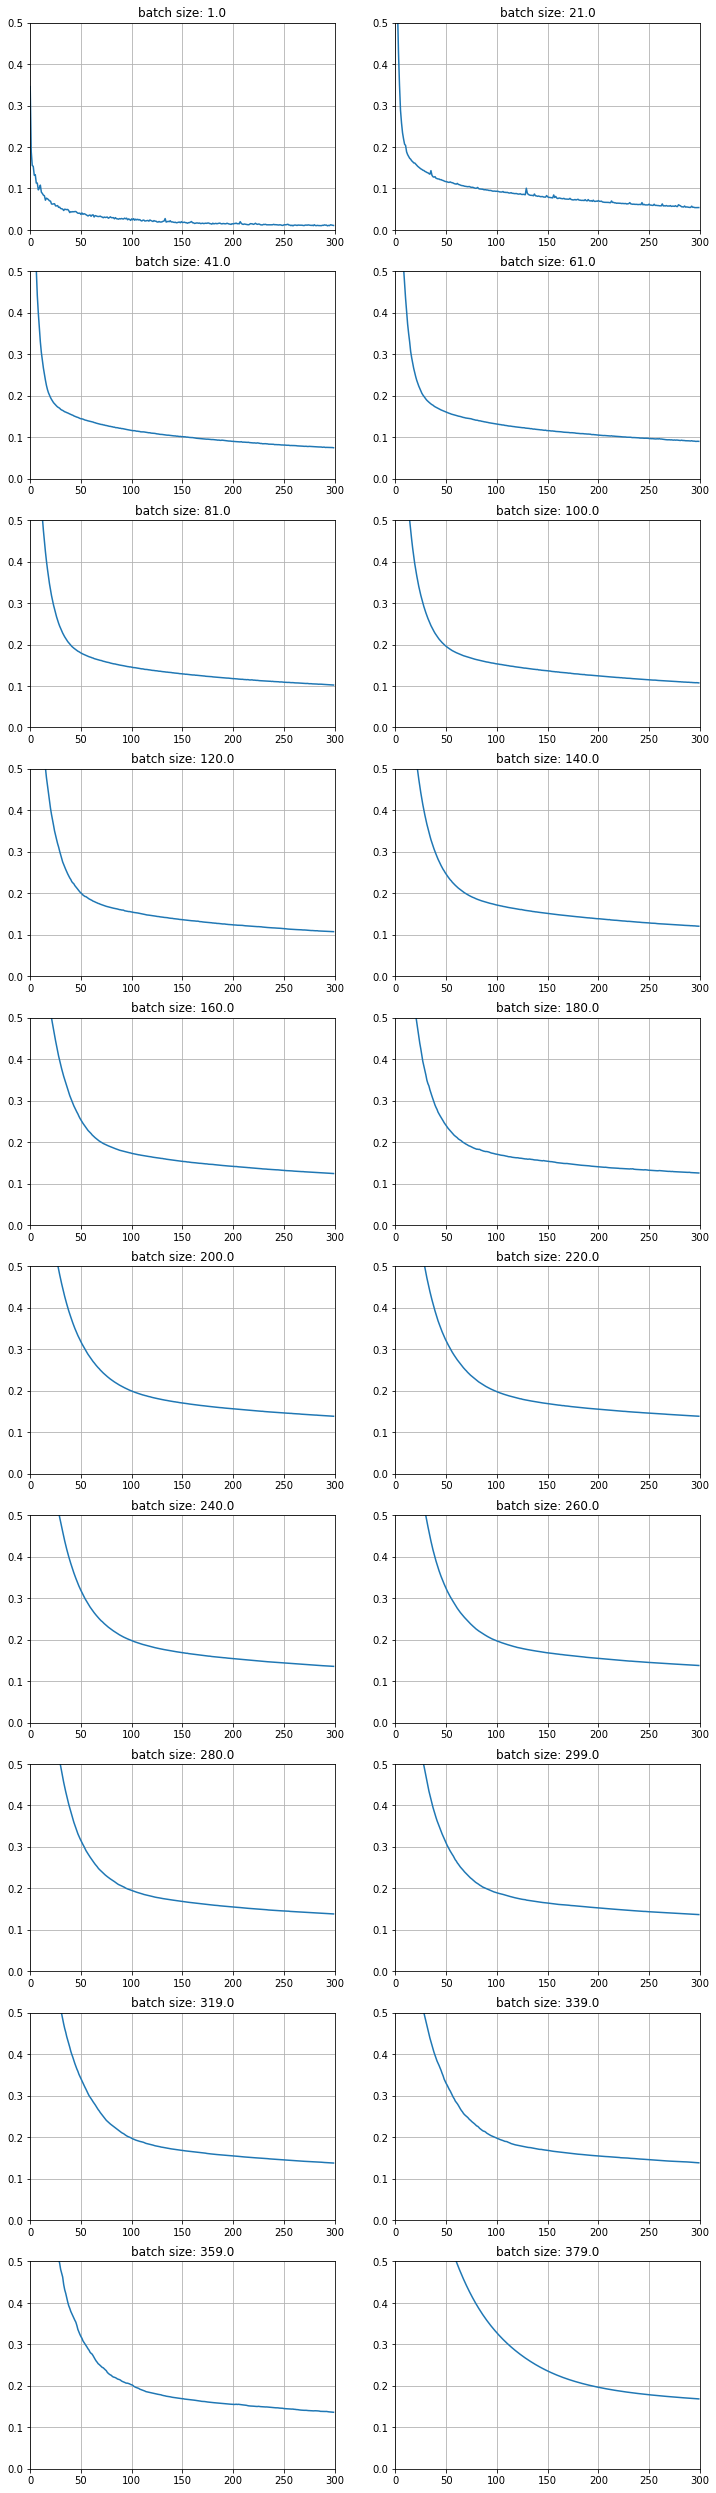

In [32]:
n_batches = 20
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))

x_cord=[i%2 for i in xrange(20)]
y_cord=[i/2 for i in xrange(20)]

f, axarr = plt.subplots(10, 2,figsize=(12,45))
for batch,x,y in zip(batch_sizes,x_cord,y_cord):
    sgd = SGD(lr=0.01)
    model = do_model(Xm_train.shape[1], 'relu', sgd)
    
    # fit the model
    hist = model.fit(Xm_train, ym_train, batch_size=batch, epochs=300, verbose=0, validation_data=(Xm_test, ym_test))
    
    axarr[y, x].plot(hist.history['loss'])
    axarr[y, x].set_title('batch size: '+(str(batch)))
    axarr[y, x].axis([0, 300, 0, .5])
    axarr[y, x].grid(True)
    
plt.show()

## Estrategias  modernas  para  adaptar  la  tasa  de aprendizaje

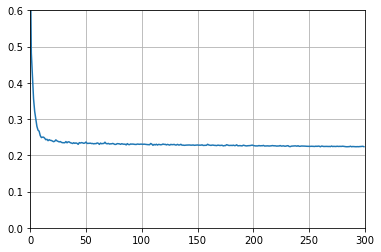

In [52]:
# adagard

moptimizer = Adagrad(lr=0.01)
model = do_model(Xm_train.shape[1], 'sigmoid', moptimizer)

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)
    
plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, .6])
plt.grid(True)
plt.show()

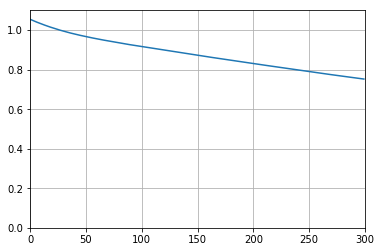

In [53]:
# Adadelta

moptimizer = Adadelta(lr=0.01)
model = do_model(Xm_train.shape[1], 'sigmoid', moptimizer)

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)
    
plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 1.1])
plt.grid(True)
plt.show()

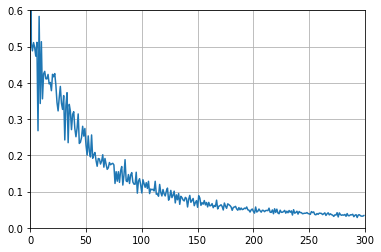

In [55]:
# RMSprop

moptimizer = RMSprop(lr=0.01)
model = do_model(Xm_train.shape[1], 'sigmoid', moptimizer)

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)
    
plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 0.6])
plt.grid(True)
plt.show()

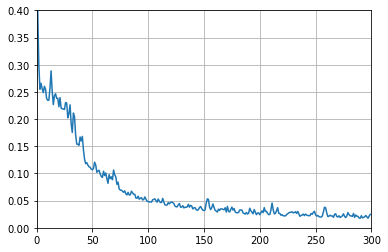

In [56]:
# adam

moptimizer = Adam(lr=0.01)
model = do_model(Xm_train.shape[1], 'sigmoid', moptimizer)

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)
    
plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 0.4])
plt.grid(True)
plt.show()

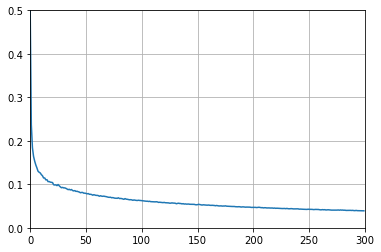

In [41]:
# adagard

moptimizer = Adagrad(lr=0.01)
model = do_model(Xm_train.shape[1], 'relu', moptimizer)

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)
    
plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, .5])
plt.grid(True)
plt.show()

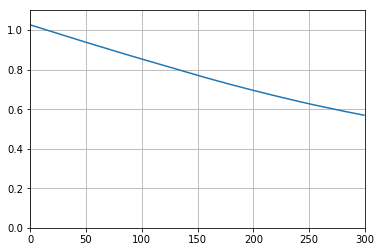

In [46]:
# Adadelta

moptimizer = Adadelta(lr=0.01)
model = do_model(Xm_train.shape[1], 'relu', moptimizer)

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)
    
plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 1.1])
plt.grid(True)
plt.show()

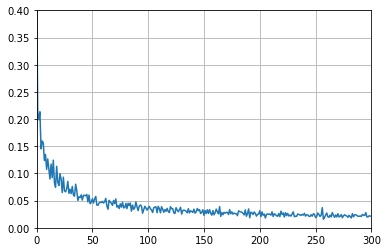

In [49]:
# RMSprop

moptimizer = RMSprop(lr=0.01)
model = do_model(Xm_train.shape[1], 'relu', moptimizer)

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)
    
plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 0.4])
plt.grid(True)
plt.show()

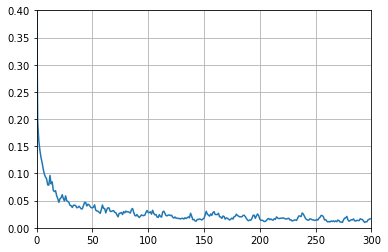

In [50]:
# adam

moptimizer = Adam(lr=0.01)
model = do_model(Xm_train.shape[1], 'relu', moptimizer)

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)
    
plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 0.4])
plt.grid(True)
plt.show()

## regularizadores l1 y l2

C:\Users\tres1\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, kernel_regularizer=<keras.reg..., kernel_initializer="uniform", input_dim=13)`
  
C:\Users\tres1\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., kernel_initializer="uniform")`
  after removing the cwd from sys.path.


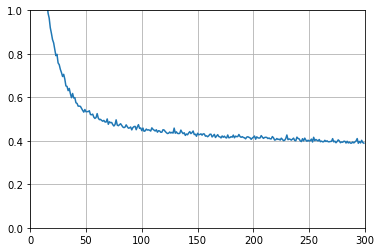

In [71]:
model = Sequential()
model.add(Dense(200, input_dim=Xm_train.shape[1], kernel_initializer='uniform', W_regularizer=l1(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform', W_regularizer=l2(0.01)))
model.add(Activation('linear'))

sgd = SGD(lr=0.01)
model.compile(optimizer = sgd, loss='mean_squared_error')

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)

plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 1])
plt.grid(True)
plt.show()

C:\Users\tres1\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, kernel_regularizer=<keras.reg..., kernel_initializer="uniform", input_dim=13)`
  
C:\Users\tres1\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., kernel_initializer="uniform")`
  after removing the cwd from sys.path.


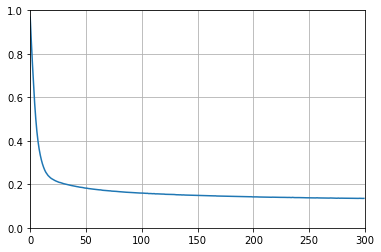

In [70]:
model = Sequential()
model.add(Dense(200, input_dim=Xm_train.shape[1], kernel_initializer='uniform', W_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform', W_regularizer=l2(0.01)))
model.add(Activation('linear'))

sgd = SGD(lr=0.01)
model.compile(optimizer = sgd, loss='mean_squared_error')

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)

plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 1])
plt.grid(True)
plt.show()

## Dropout

C:\Users\tres1\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, kernel_initializer="uniform", input_dim=13)`
  after removing the cwd from sys.path.
C:\Users\tres1\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`
  import sys


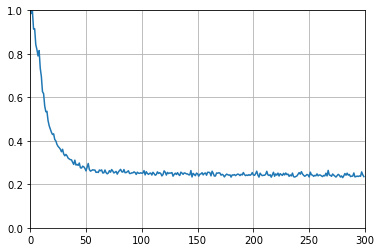

In [76]:
model = Sequential()

idim=X_train_scaled.shape[1]
model.add(Dense(200,input_dim=Xm_train.shape[1],init='uniform'))
model.add(Dropout(0.2))
model.add(Activation('sigmoid'))
model.add(Dense(1, init='uniform'))
model.add(Activation('linear'))

sgd = SGD(lr=0.01)
model.compile(optimizer = sgd, loss='mean_squared_error')

hist = model.fit(Xm_train, ym_train, epochs=300, verbose=0)

plt.plot(hist.history['loss'])
plt.axis([0, 300, 0, 1])
plt.grid(True)
plt.show()

In [ ]:
kfold = cross_validation.KFold(len(Xm_train), 10)

cvscores = []
for i, (train, val) in enumerate(kfold):
    sgd = SGD(lr=0.02)
    model = do_model(Xm_train.shape[1], 'sigmoid', sgd)
    
    model.fit(Xm_train[train], ym_train[train], epochs=300, verbose=0)
    
    scores = model.evaluate( Xm_train[val], ym_train[val] )
    cvscores.append(scores)
    
mse_cv = np.mean(cvscores)
mse_cv